In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

In [2]:
fileroot='2024_03_08_TRF_Maleen/'
filename='2024_03_08_TRF_Maleen_01'

datapath='/home/maleen/rosbags/Transformers/datasets/training/'

# Load the DataFrame from the pickle file
df1 = pd.read_pickle(datapath + filename + '.pkl')

arrays = [np.array(item) for item in df1['Skeleton_3D']]
timestamps = [np.array(item) for item in df1['Skeleton_Timestamp']]

# Convert datetime to seconds from start
timestamps = (timestamps - timestamps[0])

# Stack these arrays along a new axis to create a 3D NumPy array
# Each "slice" of this 3D array represents one frame of keypoints
skeleton_3d_frames = np.stack(arrays, axis=0)

In [3]:
#Create masks for the data (1 = data present, 0 = data missing)
# Correcting the mask values
masks = np.where(np.isnan(skeleton_3d_frames).any(axis=2), 0, 1)  # 0 for missing, 1 for present

In [4]:
# Calculate the differences in position and time
position_diff = np.diff(skeleton_3d_frames, axis=0)
time_diff = np.diff(timestamps)

# Ensure that time_diff is of shape (n,1,1) so that it broadcasts correctly when dividing
time_diff = time_diff[:, np.newaxis, np.newaxis]

# Update masks to match the dimensions of position_diff and time_diff
# We use the bitwise AND operator to ensure that both the current and previous frames are valid
masks_pos = masks[:-1, :] & masks[1:, :]

# Add an additional dimension to masks
masks_pos = masks_pos[:,:,np.newaxis]

# Now we calculate velocity, handling missing data according to the mask
# Where the mask is False, we will get np.nan
skel_vel = np.where(masks_pos, position_diff / time_diff, np.nan)

masks_velocity = masks_pos[:-1, :] & masks_pos[1:, :]

# Calculate the differences in velocity
velocity_diff = np.diff(skel_vel, axis=0)

# Now we calculate acceleration, handling missing data according to the mask
# Where the mask is False, we will get np.nan
skel_acc = np.where(masks_velocity, velocity_diff / time_diff[:-1, :, :], np.nan)  # Use time_diff with one less time dimension

In [5]:
# Now, slice skeleton_3d_frames and skel_vel to match the dimensions of skell_acc
skel_pos= skeleton_3d_frames[2:]
skel_vel = skel_vel[1:]
masks = masks[2:]

In [6]:
# Initialize arrays to hold the normalized data, medians, and IQRs
norm_pos = np.empty_like(skel_pos)
medians_per_joint_axis_skel_pos = np.empty((skel_pos.shape[1], skel_pos.shape[2]))
iqrs_per_joint_axis_skel_pos = np.empty((skel_pos.shape[1], skel_pos.shape[2]))

norm_vel= np.empty_like(skel_vel)
medians_per_joint_axis_vel = np.empty((skel_vel.shape[1], skel_vel.shape[2]))
iqrs_per_joint_axis_vel = np.empty((skel_vel.shape[1], skel_vel.shape[2]))

norm_acc = np.empty_like(skel_acc)
medians_per_joint_axis_acc = np.empty((skel_acc.shape[1], skel_acc.shape[2]))
iqrs_per_joint_axis_acc = np.empty((skel_acc.shape[1], skel_acc.shape[2]))

def robust_normalize_data_with_clipping(data, masks, medians_per_joint_axis, iqrs_per_joint_axis, normalized_data, clipping_percentiles=(1, 99)):
    for joint in range(data.shape[1]):  # For each joint
        for axis in range(data.shape[2]):  # For each axis (x, y, z)
            joint_axis_data = data[:, joint, axis]
            mask_for_joint = masks[:, joint]

            # Select valid data based on the mask
            valid_data = joint_axis_data[mask_for_joint == 1]

            # Determine clipping thresholds based on percentiles
            lower_threshold, upper_threshold = np.percentile(valid_data, clipping_percentiles) if valid_data.size > 0 else (np.nan, np.nan)

            # Clip the data based on valid mask and thresholds
            clipped_values = np.clip(joint_axis_data, lower_threshold, upper_threshold)

            # Calculate median and IQR for clipped data
            median = np.median(clipped_values[mask_for_joint == 1]) if np.any(mask_for_joint == 1) else np.nan
            q75, q25 = np.percentile(clipped_values[mask_for_joint == 1], [75 ,25]) if np.any(mask_for_joint == 1) else (np.nan, np.nan)
            iqr = q75 - q25

            # Store the calculated medians and IQRs
            medians_per_joint_axis[joint, axis] = median
            iqrs_per_joint_axis[joint, axis] = iqr

            # Normalize the clipped data, avoiding division by zero
            if iqr > 0:
                normalized_values = (clipped_values - median) / iqr
            else:
                normalized_values = clipped_values  # Keep original values if IQR is 0 or nan

            # Apply normalization only where data is present
            normalized_data[:, joint, axis] = np.where(mask_for_joint == 1, normalized_values, np.nan)
            
    return normalized_data, medians_per_joint_axis, iqrs_per_joint_axis

# Example usage with your data
# Note: masks, skel_pos, skel_vel, skel_acc should be defined in your context

norm_pos, medians_pos, iqrs_pos = robust_normalize_data_with_clipping(skel_pos, masks, medians_per_joint_axis_skel_pos, iqrs_per_joint_axis_skel_pos, norm_pos)
norm_vel, medians_vel, iqrs_vel = robust_normalize_data_with_clipping(skel_vel, masks, medians_per_joint_axis_vel, iqrs_per_joint_axis_vel, norm_vel)
norm_acc, medians_acc, iqrs_acc = robust_normalize_data_with_clipping(skel_acc, masks, medians_per_joint_axis_acc, iqrs_per_joint_axis_acc, norm_acc)


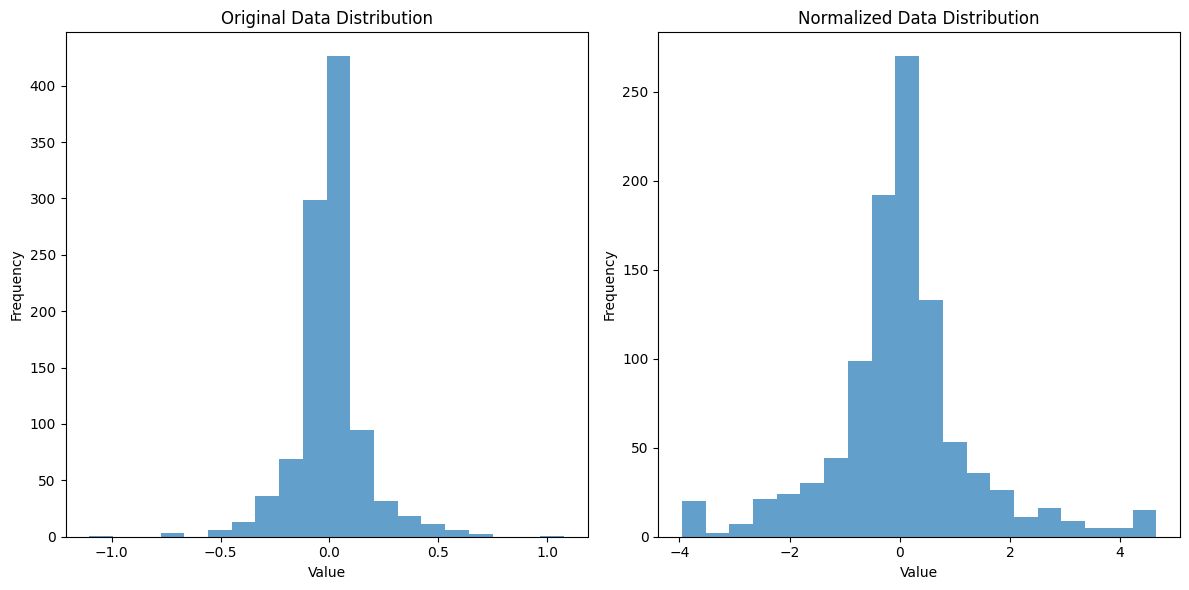

Median of normalized data: 1.951563910473908e-18
Data points within [-1, 1] (IQR): 892 out of 1018
Data points within [-1, 1] (IQR): 1016 out of 1018


In [7]:
data=skel_vel
norm_data=norm_vel
# Plot the original and normalized data for a specific joint and axis
joint, axis = 0, 0  # Change as needed
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data[:, joint, axis], bins=20, alpha=0.7, label='Original')
plt.title("Original Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(norm_data[:, joint, axis], bins=20, alpha=0.7, label='Normalized')
plt.title("Normalized Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Check the median and range of the normalized data
normalized_median = np.nanmedian(norm_data[:, joint, axis])
print("Median of normalized data:", normalized_median)

within_iqr = ((norm_data[:, joint, axis] > -2) & (norm_data[:, joint, axis] < 2)).sum()
print(f"Data points within [-1, 1] (IQR): {within_iqr} out of {norm_data.shape[0]}")

within_iqr2 = ((data[:, joint, axis] > -1) & (data[:, joint, axis] < 1)).sum()
print(f"Data points within [-1, 1] (IQR): {within_iqr2} out of {norm_data.shape[0]}")

In [15]:
#Sequence Generation

# Determine the number of frames
num_frames = norm_pos.shape[0]

# Compute the number of sequences
num_sequences = num_frames // 60  # This uses integer division, so any extra frames are dropped

# Create the sequences
pos_seqs = [norm_pos[i*60:(i+1)*60] for i in range(num_sequences)]
vel_seqs = [norm_vel[i*60:(i+1)*60] for i in range(num_sequences)]
acc_seqs = [norm_acc[i*60:(i+1)*60] for i in range(num_sequences)]
# Create the mask sequences
mask_seqs = [masks[i*60:(i+1)*60] for i in range(num_sequences)]



In [9]:

class SkeletalInputEmbedding(nn.Module):
    def __init__(self, num_joints=18, dof=3, embed_dim=128, seq_len=60):
        super().__init__()
        self.num_joints = num_joints
        self.dof = dof
        self.seq_len = seq_len
        self.embed_dim = embed_dim

        # Embedding layers for each DOF of the joints
        self.joint_embed = nn.Linear(dof, embed_dim)
        self.vel_embed = nn.Linear(dof, embed_dim)
        self.acc_embed = nn.Linear(dof, embed_dim)

        # Move the model to the GPU before initializing the positional encoding
        self.to('cuda')  # Ensure the model and its parameters are on GPU

        # Initialize positional encoding as a registered buffer
        self.register_buffer('positional_encoding', self.get_sinusoidal_encoding(seq_len * num_joints, embed_dim))

    def forward(self, joint_positions, velocities, accelerations, mask=None):
        joint_positions = joint_positions.view(-1, self.seq_len * self.num_joints, self.dof)
        velocities = velocities.view(-1, self.seq_len * self.num_joints, self.dof)
        accelerations = accelerations.view(-1, self.seq_len * self.num_joints, self.dof)

        if mask is not None:
            joint_positions = joint_positions * mask.view(-1, self.seq_len * self.num_joints, self.dof)
            velocities = velocities * mask.view(-1, self.seq_len * self.num_joints, self.dof)
            accelerations = accelerations * mask.view(-1, self.seq_len * self.num_joints, self.dof)

        joint_embeddings = self.joint_embed(joint_positions)
        vel_embeddings = self.vel_embed(velocities)
        acc_embeddings = self.acc_embed(accelerations)

        # Combine embeddings
        combined_embeddings = joint_embeddings + vel_embeddings + acc_embeddings

        # Add positional encoding
        combined_embeddings += self.positional_encoding[:combined_embeddings.size(1), :].unsqueeze(0)

        # Reshaping back to (batch_size, seq_len, num_joints, embed_dim)
        combined_embeddings = combined_embeddings.view(-1, self.seq_len, self.num_joints, self.embed_dim)

        return combined_embeddings

    def get_sinusoidal_encoding(self, seq_len, embed_dim):
        pe = torch.zeros(seq_len, embed_dim, device=self.device)  # Use self.device to match the model's device
        position = torch.arange(0, seq_len, dtype=torch.float, device=self.device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2, device=self.device).float() * -(np.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    @property
    def device(self):
        return next(self.parameters()).device
        
# Use the model
embedding_layer = SkeletalInputEmbedding()
# Ensure input tensors are also on GPU
joint_positions = torch.rand(32, 60, 18, 3).cuda()
velocities = torch.rand(32, 60, 18, 3).cuda()
accelerations = torch.rand(32, 60, 18, 3).cuda()


# Forward pass through the embedding layer
embedded_input = embedding_layer(joint_positions, velocities, accelerations)
print(embedded_input.shape)  # Expected shape: torch.Size([32, 60, 18, embed_dim])



torch.Size([32, 60, 18, 128])


In [17]:
# Assuming the SkeletalInputEmbedding class is already defined and initialized
model = SkeletalInputEmbedding()

# Function to convert sequences to tensors and move to GPU
def seqs_to_tensors(seqs):
    return [seq.clone().detach().to('cuda', dtype=torch.float32) if torch.is_tensor(seq) else torch.tensor(seq, dtype=torch.float32).cuda() for seq in seqs]


# Convert all sequences to tensors and move to GPU
pos_seqs_tensors = seqs_to_tensors(pos_seqs)
vel_seqs_tensors = seqs_to_tensors(vel_seqs)
acc_seqs_tensors = seqs_to_tensors(acc_seqs)
mask_seqs_tensors = seqs_to_tensors(mask_seqs)

# Iterate over the sequences and pass them through the model
for pos_seqs, vel_seqs, acc_seqs, mask_seqs in zip(pos_seqs_tensors, vel_seqs_tensors, acc_seqs_tensors, mask_seqs_tensors):
    # Assuming your mask is a binary mask with 1s for present data and 0s for missing data
    # The mask should be expanded to match the DOF (3 in this case) since the original mask might be (60, 18)
    mask_seq_expanded = mask_seqs.unsqueeze(-1).expand(-1, -1, 3)  # Expand the last dimension to match DOF

    # Forward pass through the model
    embedded_output = model(pos_seqs, vel_seqs, acc_seqs, mask_seq_expanded)
    print(embedded_output.shape)  # Expected shape: torch.Size([1, 60, 18, embed_dim])

    # You can now process embedded_output as needed


torch.Size([1, 60, 18, 128])
torch.Size([1, 60, 18, 128])
torch.Size([1, 60, 18, 128])
torch.Size([1, 60, 18, 128])
torch.Size([1, 60, 18, 128])
torch.Size([1, 60, 18, 128])
torch.Size([1, 60, 18, 128])
torch.Size([1, 60, 18, 128])
torch.Size([1, 60, 18, 128])
torch.Size([1, 60, 18, 128])
torch.Size([1, 60, 18, 128])
torch.Size([1, 60, 18, 128])
torch.Size([1, 60, 18, 128])
torch.Size([1, 60, 18, 128])
torch.Size([1, 60, 18, 128])
torch.Size([1, 60, 18, 128])


In [18]:
print(mask_seqs.shape) 

torch.Size([60, 18])
